In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
from scipy.stats import pearsonr
from scipy.stats import bernoulli
import numpy as np
import statistics as stats
import math
import random
from unidecode import unidecode

In [2]:
sample = pd.read_csv(open('MLB-PbP-Sample.csv'))

In [3]:
df_2022 = pd.read_csv(open('2022_MLB_PbP_Logs.csv'))

In [4]:
reg_df = df_2022.loc[df_2022['BIGDATABALL\nDATASET'] == 'MLB 2022 Regular Season']

In [5]:
# Weights are based on expected run values
weights = [-0.26,-0.25,-0.2,0.3,-0.23,0,0.75,-0.31,0.44,0.31,-0.23,-0.75,0,1.37,0.49,-0.1,-0.75,-0.31,0.18,1.02,0.3]
play_weights = dict(zip(df_2022['PLAY TYPE'].unique(), weights))

In [6]:
def update(winner, loser, w):
    K = 10*w
    s = 400
    return round(K / (1 + math.exp((winner - loser)/s)))

In [7]:
batters = reg_df['BATTER'].unique()
batter_elos = dict(zip(batters, ([] for _ in batters)))

pitchers = reg_df['PITCHER'].unique()
pitcher_elos = dict(zip(pitchers, ([] for _ in pitchers)))

In [8]:
# Initialize df for batting and pitching Elo
batting_df = pd.DataFrame(columns = ['Name', 'L/R', 'RElo', 'LElo','Elo'])
pitching_df = pd.DataFrame(columns = ['Name', 'L/R', 'RElo', 'LElo','Elo'])

for row in reg_df.iterrows():
    # If batter is not yet in dataframe
    if (row[1]['BATTER'] in batting_df['Name'].values) == False :
        batting_df = batting_df.append({'Name' : row[1]['BATTER'], 'L/R' : row[1]['BATTER\nHAND'], 'RElo' : 1500, 'LElo' : 1500, 'Elo' : 1500},
        ignore_index = True)
    # If pitcher is not yet in dataframe
    if (row[1]['PITCHER'] in pitching_df['Name'].values) == False :
        pitching_df = pitching_df.append({'Name' : row[1]['PITCHER'], 'L/R' : row[1]['PITCHER\nHAND'], 'RElo' : 1500, 'LElo' : 1500, 'Elo' : 1500},
        ignore_index = True)
        
    # Get index of hitter and pitcher
    bi = batting_df.index[batting_df['Name'] == row[1]['BATTER']][0]
    pi = pitching_df.index[pitching_df['Name'] == row[1]['PITCHER']][0]
    
    # Get pitcher and hitter overall Elo
    bElo = batting_df.loc[bi, 'Elo']
    pElo = pitching_df.loc[pi, 'Elo']
    
    # Update Elos based on outcome of PAs
    if math.isnan(row[1]['OUTS']):
        bElo += update(bElo, pElo, play_weights[row[1]['PLAY TYPE']])
        pElo -= update(bElo, pElo, play_weights[row[1]['PLAY TYPE']])
    else:
        bElo += update(pElo, bElo, play_weights[row[1]['PLAY TYPE']])
        pElo -= update(pElo, bElo, play_weights[row[1]['PLAY TYPE']])
        
    # Temporary for plot purposes
    batter_elos[row[1]['BATTER']].append(bElo)
    pitcher_elos[row[1]['PITCHER']].append(pElo)
        
    batting_df.at[bi,'Elo'] = bElo
    pitching_df.at[pi,'Elo'] = pElo

In [9]:
for row in reg_df.iterrows():
    # Get index of hitter and pitcher
    bi = batting_df.index[batting_df['Name'] == row[1]['BATTER']][0]
    pi = pitching_df.index[pitching_df['Name'] == row[1]['PITCHER']][0]
    
    # Determine whether to update RElo or LElo
    if row[1]['BATTER\nHAND'] == 'L':
        phElo = pitching_df.loc[pi, 'LElo']
    elif row[1]['BATTER\nHAND']  == 'R':
        phElo = pitching_df.loc[pi, 'RElo']
    else :
        # For switch hitter, bats from opposite side as pitcher
        if row[1]['PITCHER\nHAND']  == 'L':
            phElo = pitching_df.loc[pi, 'RElo']
        else:
            phElo = pitching_df.loc[pi, 'LElo']
            
    if row[1]['PITCHER\nHAND']  == 'L':
        bhElo = batting_df.loc[bi, 'LElo']
    else :
        bhElo = batting_df.loc[bi, 'RElo']
    
    # Update Elos based on outcome of PAs
    if math.isnan(row[1]['OUTS']):   
        bhElo += update(bhElo, phElo, play_weights[row[1]['PLAY TYPE']])
        phElo -= update(bhElo, phElo, play_weights[row[1]['PLAY TYPE']])
    else:
        bhElo += update(phElo, bhElo, play_weights[row[1]['PLAY TYPE']])
        phElo -= update(phElo, bhElo, play_weights[row[1]['PLAY TYPE']])
    
    if row[1]['BATTER\nHAND'] == 'L':
        pitching_df.at[pi,'LElo'] = phElo
    elif row[1]['BATTER\nHAND'] == 'R':
        pitching_df.at[pi,'RElo'] = phElo
    else :
        if row[1]['PITCHER\nHAND'] == 'L':
            pitching_df.at[pi,'RElo'] = phElo
        else:
            pitching_df.at[pi,'LElo'] = phElo
            
    if row[1]['PITCHER\nHAND'] == 'L':
        batting_df.at[bi,'LElo'] = bhElo
    else :
        batting_df.at[bi,'RElo'] = bhElo

In [353]:
pitching_df = pitching_df.sort_values(by='Elo', ascending=False)
pitching_df.head(10)

,Name,L/R,RElo,LElo,Elo
286,Justin Verlander,R,1539,1601,1623
263,Emmanuel Clase,R,1561,1544,1598
132,Sandy Alcantara,R,1532,1583,1596
477,Zac Gallen,R,1511,1597,1593
37,Max Fried,L,1558,1532,1585
280,Tony Gonsolin,R,1529,1564,1584
46,Shohei Ohtani,R,1563,1519,1579
356,Evan Phillips,R,1543,1535,1578
102,Shane McClanahan,L,1567,1510,1576
36,Edwin Diaz,R,1533,1544,1573


In [431]:
batting_df = batting_df.sort_values(by='Elo', ascending=False)
batting_df.head(10)

,Name,L/R,RElo,LElo,Elo
147,Aaron Judge,R,1721,1563,1731
222,Freddie Freeman,L,1665,1548,1677
104,Yordan Alvarez,L,1624,1582,1657
107,Mike Trout,R,1619,1574,1655
46,Paul Goldschmidt,R,1616,1619,1653
101,Jose Altuve,R,1591,1584,1647
249,Julio Rodriguez,R,1617,1536,1641
106,Shohei Ohtani,L,1618,1549,1637
121,Manny Machado,R,1629,1541,1632
221,Mookie Betts,R,1585,1568,1628


In [103]:
pRLdiff = np.subtract(list(pitching_df['RElo']), list(pitching_df['LElo']))
bRLdiff = np.subtract(list(batting_df['RElo']), list(batting_df['LElo']))

-1
1024.9024943310658
-0.5
821.0201148357366


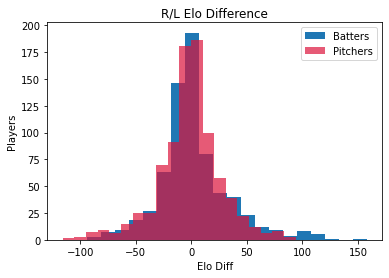

In [356]:
plt.hist(bRLdiff, bins = 20, label = "Batters")
plt.hist(pRLdiff, bins = 20, color = 'crimson', alpha=0.7, label = "Pitchers")

plt.xlabel("Elo Diff")
plt.ylabel("Players")
plt.title("R/L Elo Difference")

plt.legend(loc="upper right")

plt.savefig('diffhist.png')

print(stats.median(bRLdiff))
print(np.var(bRLdiff))

print(stats.median(pRLdiff))
print(np.var(pRLdiff))

1493.9481566820277
855.5791095054045
1508.878787878788
1437.7601993965632


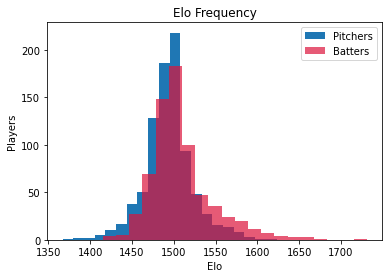

In [350]:
plt.hist(list(pitching_df['Elo']), bins = 20, label = "Pitchers")
plt.hist(list(batting_df['Elo']), bins = 20, color = 'crimson', alpha=0.7, label = "Batters")

plt.xlabel("Elo")
plt.ylabel("Players")
plt.title("Elo Frequency")

plt.legend(loc="upper right")

plt.savefig('elohist.png')

print(stats.mean(pitching_df['Elo']))
print(np.var(pitching_df['Elo']))

print(stats.mean(batting_df['Elo']))
print(np.var(batting_df['Elo']))

In [360]:
# Batting leaderboard from BaseballReference
batting_leaders = pd.read_csv(open('batting_leaders.csv'))
batting_leaders['Name'] = batting_leaders['Name'].str.replace(r'[*#]', '', regex=True)
batting_leaders['Name'] = batting_leaders['Name'].str.replace(r'\xa0', ' ', regex=True)
    
ops = []
elos = []

# Starting pitching leaderboard from BaseballReference
sp_leaders = pd.read_csv(open('sp_leaders.csv'))
sp_leaders['Name'] = sp_leaders['Name'].str.replace(r'[*#]', '', regex=True)
sp_leaders['Name'] = sp_leaders['Name'].str.replace(r'\xa0', ' ', regex=True)
    
era = []
elos2 = []

# Relief pitching leaderboard from BaseballReference
rp_leaders = pd.read_csv(open('rp_leaders.csv'))
rp_leaders['Name'] = rp_leaders['Name'].str.replace(r'[*#]', '', regex=True)
rp_leaders['Name'] = rp_leaders['Name'].str.replace(r'\xa0', ' ', regex=True)
    
era2 = []
elos3 = []

In [361]:
# Get OPS and Elo pairs
for row in batting_leaders.iterrows():
    r = batting_df.loc[batting_df['Name'] == row[1]['Name'], 'Elo']
    if len(r) != 0:
        ops.append(row[1]['OPS'])
        
        elo = r.iloc[0]
        elos.append(elo)

# Get OPS and Elo pairs
for row in sp_leaders.iterrows():
    r = pitching_df.loc[pitching_df['Name'] == row[1]['Name'], 'Elo']
    if len(r) != 0:
        era.append(row[1]['ERA'])
        
        elo = r.iloc[0]
        elos2.append(elo)
        
# Get OPS and Elo pairs
for row in rp_leaders.iterrows():
    r = pitching_df.loc[pitching_df['Name'] == row[1]['Name'], 'Elo']
    if len(r) != 0:
        era2.append(row[1]['ERA'])
        
        elo = r.iloc[0]
        elos3.append(elo)

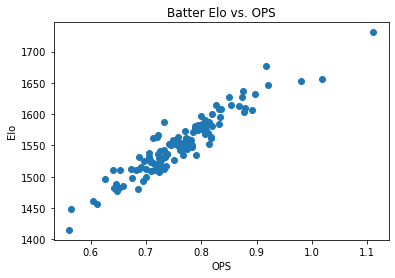

(0.9459964344646936, 1.3346956513486163e-57)

In [362]:
plt.scatter(ops, elos)
plt.xlabel("OPS")
plt.ylabel("Elo")
plt.title("Batter Elo vs. OPS")

plt.savefig('elovops.png')
plt.show()

pearsonr(ops, elos)

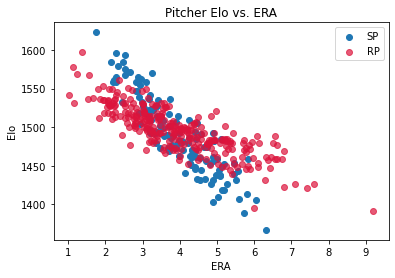

(-0.9022684114838007, 1.5530305854008902e-51)
(-0.8249771720621224, 7.3672726458727e-71)


In [363]:
plt.scatter(era, elos2, label = 'SP')
plt.scatter(era2, elos3, color = 'crimson', alpha = 0.7, label = 'RP')
plt.xlabel("ERA")
plt.ylabel("Elo")
plt.title("Pitcher Elo vs. ERA")
plt.legend(loc="upper right")

plt.savefig('elovera.png')
plt.show()

print(pearsonr(era, elos2))
print(pearsonr(era2, elos3))

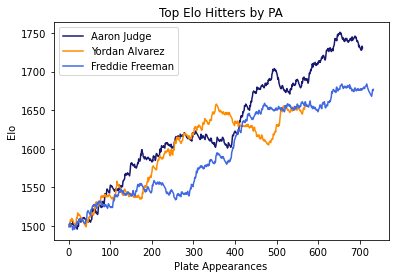

In [59]:
#player1 = random.sample(batter_elos.keys(), 1)[0]
#player2 = random.sample(batter_elos.keys(), 1)[0]
#c = np.random.rand(3,)

player1 = "Aaron Judge"
player3 = "Yordan Alvarez"
player4 = "Freddie Freeman"


plt.plot(batter_elos[player1], c = 'midnightblue')
plt.plot(batter_elos[player3], c = 'darkorange')
plt.plot(batter_elos[player4], c = 'royalblue')

plt.xlabel("Plate Appearances")
plt.ylabel("Elo")
plt.title("Top Elo Hitters by PA")
plt.legend([player1, player3, player4])

plt.savefig('hitter_elo_plot.png')
plt.show()

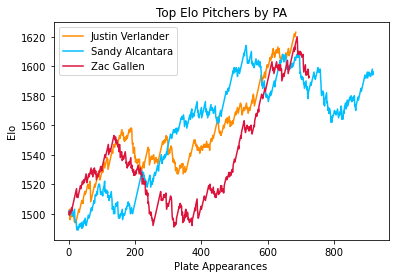

In [75]:
#player1 = random.sample(pitcher_elos.keys(), 1)[0]
#player2 = random.sample(pitcher_elos.keys(), 1)[0]

player1 = "Justin Verlander"
player2 = "Sandy Alcantara"
player3 = "Zac Gallen"

plt.plot(pitcher_elos[player1], c = 'darkorange')
plt.plot(pitcher_elos[player2], c = 'deepskyblue')
plt.plot(pitcher_elos[player3], c = 'crimson')

plt.xlabel("Plate Appearances")
plt.ylabel("Elo")
plt.title("Top Elo Pitchers by PA")
plt.legend([player1, player2, player3])

plt.savefig('pitcher_elo_plot.png')
plt.show()

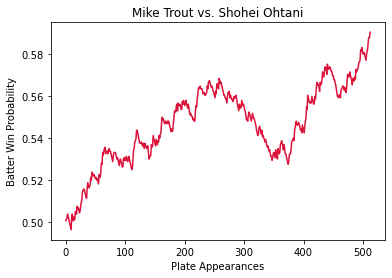

In [398]:
#batter = random.sample(batter_elos.keys(), 1)[0]
#pitcher = random.sample(pitcher_elos.keys(), 1)[0]

batter = "Mike Trout"
pitcher = "Shohei Ohtani"

#bElo = batting_df.loc[batting_df['Name'] == batter, 'Elo'].iloc[0]
#pElo = pitching_df.loc[pitching_df['Name'] == pitcher, 'Elo'].iloc[0]

min_len = min(len(pitcher_elos[pitcher]), len(batter_elos[batter]))
diffs = np.subtract(pitcher_elos[pitcher][:min_len], batter_elos[batter][:min_len])
probs = 1 / (1 + np.exp((diffs)/400))

plt.plot(probs, c = 'crimson')

plt.xlabel("Plate Appearances")
plt.ylabel("Batter Win Probability")
plt.title(batter + " vs. " + pitcher)

plt.savefig('troutvohtani.png')
plt.show()

In [400]:
batter = "Mike Trout"
pitcher = "Shohei Ohtani"
#obp = batting_leaders.loc[batting_leaders['Name'] == batter, 'OBP'].iloc[0]

bElo = bElo = batting_df.loc[batting_df['Name'] == batter, 'Elo'].iloc[0]
pElo = pitching_df.loc[pitching_df['Name'] == pitcher, 'Elo'].iloc[0]

prob_avg = 1 / (1 + np.exp((1500 - bElo)/400))
prob_p = 1 / (1 + np.exp((pElo - bElo)/400))

#f = obp/prob_avg
f = 1
print(prob_p*f)

0.5473576181430894


In [ ]:
correct = 0
incorrect = 0

outs = 0

for row in playoff.iterrows():
    batter = 
    bElo = playoff_b_df.loc[playoff_b_df['Name'] == row[1]['BATTER'], 'Elo'].iloc[0]
    pElo = playoff_p_df.loc[playoff_p_df['Name'] == row[1]['PITCHER'], 'Elo'].iloc[0]
    
    bi = playoff_b_df.index[playoff_b_df['Name'] == row[1]['BATTER']][0]
    pi = playoff_p_df.index[playoff_p_df['Name'] == row[1]['PITCHER']][0]
    
    

In [428]:
playoff_p_df = pitching_df.copy()
playoff_b_df = batting_df.copy()
probs0 = []
probs1 = []

ylo = []
yhi = []

playoff = df_2022.loc[df_2022['BIGDATABALL\nDATASET'] == 'MLB 2022 Playoffs']

In [429]:
correct = 0
incorrect = 0

outs = 0

for row in playoff.iterrows():
    bElo = playoff_b_df.loc[playoff_b_df['Name'] == row[1]['BATTER'], 'Elo'].iloc[0]
    pElo = playoff_p_df.loc[playoff_p_df['Name'] == row[1]['PITCHER'], 'Elo'].iloc[0]
    
    bi = playoff_b_df.index[playoff_b_df['Name'] == row[1]['BATTER']][0]
    pi = playoff_p_df.index[playoff_p_df['Name'] == row[1]['PITCHER']][0]
    
    prob = 1 / (1 + np.exp((pElo - bElo)/200))
    
    pred = 0
    actual = 0
    
    if prob > 0.6:
        pred = 1
    
    if prob > 0.66:
        if math.isnan(row[1]['OUTS']):
            yhi.append(1)
        else:
            yhi.append(0)
    elif prob < 0.33:
        if math.isnan(row[1]['OUTS']):
            ylo.append(1)
        else:
            ylo.append(0)
        
    if math.isnan(row[1]['OUTS']):
        actual = 1
        probs1.append(prob)
    else:
        outs += 1
        probs0.append(prob)
        
    outcomes.append(actual)
        
    if pred == actual:
        correct += 1
    else:
        incorrect += 1
        
    # Update Elos based on outcome of PAs
    if math.isnan(row[1]['OUTS']):   
        bElo += update(bElo, pElo, play_weights[row[1]['PLAY TYPE']])
        pElo -= update(bElo, pElo, play_weights[row[1]['PLAY TYPE']])
    else:
        bElo += update(pElo, bElo, play_weights[row[1]['PLAY TYPE']])
        pElo -= update(pElo, bElo, play_weights[row[1]['PLAY TYPE']])
    
    playoff_p_df.at[pi,'Elo'] = pElo
    playoff_b_df.at[bi,'Elo'] = bElo

0.5201391304417058
0.5247679467799834


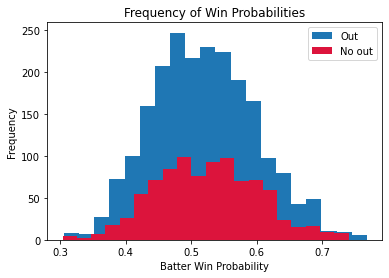

In [427]:
plt.hist(probs0, bins = 20, label = "Out")
plt.hist(probs1, bins = 20, color = 'crimson', label = "No out")

plt.xlabel("Batter Win Probability")
plt.ylabel("Frequency")
plt.legend(loc="upper right")
plt.title("Frequency of Win Probabilities")

plt.savefig('freqprobs.png')

print(stats.mean(probs0))
print(stats.mean(probs1))

array([8, 5])

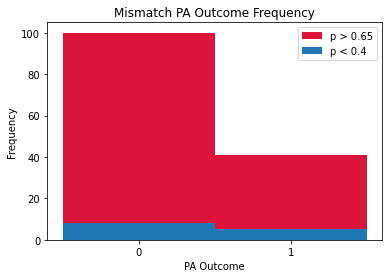

In [430]:
plt.hist(yhi, bins=[-.5,.5,1.5], color = 'crimson', label = "p > 0.65")
plt.hist(ylo, bins=[-.5,.5,1.5], label = "p < 0.4")

plt.xlabel("PA Outcome")
plt.ylabel("Frequency")
plt.legend(loc="upper right")
plt.title("Mismatch PA Outcome Frequency")

plt.xticks((0,1))

plt.savefig('paoutcome.png')

counts,_ = np.histogram(ylo, bins = 2)
counts

In [345]:
batter_diffs = {}

for player in batter_elos.keys():
    diffs = []
    
    for x, y in zip(batter_elos[player][0::], batter_elos[player][1::]):
        diffs.append(y-x)
        
    if len(diffs) > 0:
        batter_diffs[player] = stats.mean(diffs)
        
sum(batter_diffs.values())/len(batter_diffs)

-0.04463217066287368

In [346]:
pitcher_diffs = {}

for player in pitcher_elos.keys():
    diffs = []
    
    for x, y in zip(pitcher_elos[player][0::], pitcher_elos[player][1::]):
        diffs.append(y-x)
        
    if len(diffs) > 0:
        pitcher_diffs[player] = stats.mean(diffs)

sum(pitcher_diffs.values())/len(pitcher_diffs)

-0.09791735132007541